## Обучить полносвязную модель на MNIST

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import matplotlib.pyplot as plt


train_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', train = True, download=False)
test_dataset = datasets.MNIST('/home/mors/Documents/Education/Current/Learning DS/NN/Reload_NN3-master', train = False, download=False)

# Параметры
num_epoch = 8
batch_size = 256
input_d = 28*28
hidden_d = 512
out_d = 10
lr=0.001

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

True
1
0
Using device: cuda


In [2]:
# олносвязная Модель 
class NN(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 out_dim: int,
                 ):
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.dropout1 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.dropout2 = nn.Dropout(0.1)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.dropout3 = nn.Dropout(0.1)
        self.linear4 = nn.Linear(hidden_dim, out_dim)

        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.activation(self.linear1(x)))
        x = self.dropout2(self.activation(self.linear2(x)))
        x = self.dropout3(self.activation(self.linear3(x)))
        x = self.sigmoid(self.linear4(x))

        return x


def collate_fn(data):
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255, 
        'target': torch.from_numpy(numpy.array(targets))
    }

In [3]:
# Инициируем модель
modelNN = NN(input_d, hidden_d, out_d)
modelNN = modelNN.to(device)
modelNN.train()

# Оптимизатор
optim = torch.optim.Adam(modelNN.parameters(), lr=lr)

# Функция потерь
criterion = nn.CrossEntropyLoss()

In [4]:
# Тренируем
for epoch in range(num_epoch):
    print(f'epoch: {epoch}')
    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for step, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = modelNN(data.view(data.size(0), -1))
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
    print(loss)

epoch: 0
tensor(1.5177, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 1
tensor(1.4992, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 2
tensor(1.4827, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 3
tensor(1.4801, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 4
tensor(1.4844, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 5
tensor(1.4694, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 6
tensor(1.4857, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 7
tensor(1.4733, device='cuda:0', grad_fn=<NllLossBackward0>)


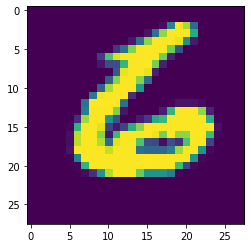

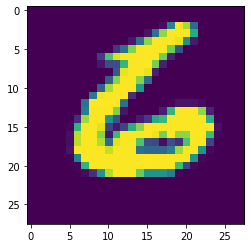

In [5]:
test = test_dataset.data[9999].view(1, -1).float() / 255

plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

predict = modelNN(test.cuda())

plt.imshow(test[0].unsqueeze(axis=0).view(28, 28).detach().numpy())
plt.show()

## Обучить глубокую сверточную сеть на MNIST

In [6]:
# Параметры
input_d = 1
hidden_d = 512
hidden_d1 = 128
hidden_d2 = 256
hidden_d3 = 128
out_d = 10

In [7]:
# Сверточная модель
class CNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels1: int,
                 hidden_channels2: int,
                 hidden_channels3: int,
                 n_classes: int,
                 ):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_channels1, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_channels1)
        self.conv2 = nn.Conv2d(hidden_channels1, hidden_channels2, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels2)
        self.conv3 = nn.Conv2d(hidden_channels2, hidden_channels3, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels3)
        self.conv4 = nn.Conv2d(hidden_channels3, 1, kernel_size=1, padding=0, stride=1)
        self.linear1 = nn.Linear(14*14, n_classes, bias=True)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.conv4(x))
        x = self.activation(self.linear1(x.view(x.size(0), -1)))

        return x


def collate_fn(data):
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255, 
        'target': torch.from_numpy(numpy.array(targets))
    }

In [8]:
# Инициируем модель
modelCNN = CNN(input_d, hidden_d1, hidden_d2, hidden_d3, out_d)
modelCNN = modelCNN.to(device)
modelCNN.train()

# Оптимизатор
optim = torch.optim.Adam(modelCNN.parameters(), lr=lr)

# Функция потерь
criterion = nn.CrossEntropyLoss()

In [9]:
# Тренируем
for epoch in range(num_epoch):
    print(f'epoch: {epoch}')
    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for step, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = modelNN(data.view(data.size(0), -1))
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
    print(loss)

epoch: 0
tensor(1.4745, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 1
tensor(1.4692, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 2
tensor(1.4762, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 3
tensor(1.4685, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 4
tensor(1.4672, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 5
tensor(1.4665, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 6
tensor(1.4716, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 7
tensor(1.4790, device='cuda:0', grad_fn=<NllLossBackward0>)
